In [61]:
#this notebook walks through:
 #loading the data
 #basic eda and plotting
 #feature engineering and preprocessing
 #training decision tree & random forest
 #cross-validation and hold-out evaluation
 #preparing the submission

In [62]:
 # suppress  future warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [63]:
# load data 
train_df = pd.read_csv(r'C:\Users\woofy\Downloads\titanic_train.csv')
test_df  = pd.read_csv(r'C:\Users\woofy\Downloads\titanic_test.csv')


missing in train:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 



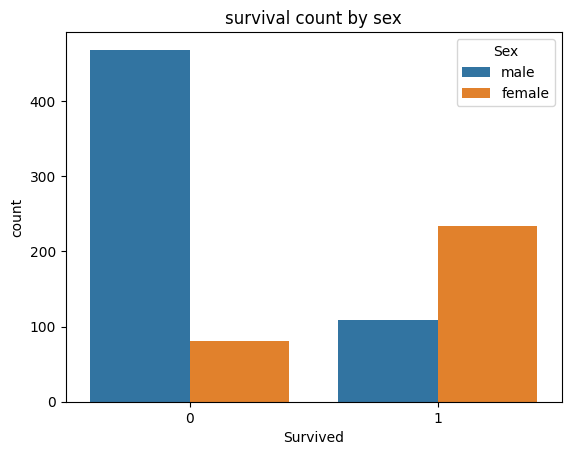

In [64]:
# check missing values and plot survival by sex
print("missing in train:\n", train_df.isnull().sum(), "\n")

sns.countplot(x='Survived', hue='Sex', data=train_df)
plt.title('survival count by sex')
plt.show()


you can see 177 missing ages and 2 missing embark locations – i will impute age next


i'll drop cabin (too many missing), embarked (only 2 missing), name and ticket (text fields not needed), and passengerid (just an identifier)


note how far more men died than women on the titanic

In [65]:
# fill missing ages with median
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())
test_df['Age']  = test_df['Age'].fillna(test_df['Age'].median())

# drop raw cabin entirely
train_df.drop(columns=['Cabin'], inplace=True, errors='ignore')
test_df.drop(columns=['Cabin'], inplace=True, errors='ignore')


In [66]:
# create age bands and fare quartiles for EDA
train_df['age_band']      = pd.cut(train_df['Age'],
                                   bins=[0,12,20,40,60,80],
                                   labels=['child','teen','adult','mid','senior'])
train_df['fare_quartile'] = pd.qcut(
    train_df['Fare'].fillna(train_df['Fare'].median()), 
    4, labels=['q1','q2','q3','q4']
)

# show survival rates
print("survival by pclass:\n", train_df.groupby('Pclass')['Survived'].mean(), "\n")
print("survival by age band:\n", train_df.groupby('age_band')['Survived'].mean(), "\n")
print("survival by fare quartile:\n", train_df.groupby('fare_quartile')['Survived'].mean(), "\n")

# combined pivots
print("pclass x age band:\n",
      train_df.pivot_table('Survived', index='Pclass', columns='age_band'), "\n")
print("pclass x fare quartile:\n",
      train_df.pivot_table('Survived', index='Pclass', columns='fare_quartile'), "\n")


survival by pclass:
 Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64 

survival by age band:
 age_band
child     0.579710
teen      0.381818
adult     0.364769
mid       0.390625
senior    0.227273
Name: Survived, dtype: float64 

survival by fare quartile:
 fare_quartile
q1    0.197309
q2    0.303571
q3    0.454955
q4    0.581081
Name: Survived, dtype: float64 

pclass x age band:
 age_band     child      teen     adult       mid    senior
Pclass                                                    
1         0.750000  0.823529  0.672269  0.580645  0.214286
2         1.000000  0.500000  0.417391  0.387097  0.333333
3         0.416667  0.253333  0.234756  0.057143  0.200000 

pclass x fare quartile:
 fare_quartile        q1        q2        q3        q4
Pclass                                               
1              0.000000       NaN  0.529412  0.685535
2              0.000000  0.383721  0.600000  0.545455
3              0.208531  0.253623  0.316832 

1- passengers in 1st class survived at ~63%, vs ~24% in 3rd class 

2- children (under 12) have a much higher survival rate (~58%) than seniors (~23%)

3- highest-fare quartile passengers survived at ~58%, cheapest quartile ~20%


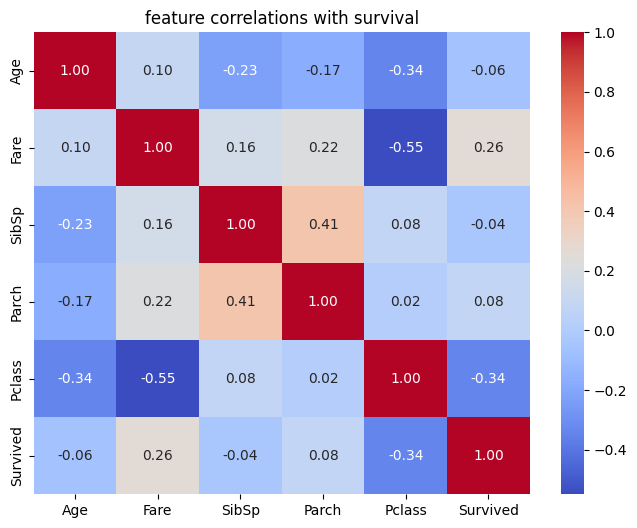

In [67]:
# correlation heatmap among numeric features
num_feats = ['Age','Fare','SibSp','Parch', 'Pclass']
corr = train_df[num_feats + ['Survived']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('feature correlations with survival')
plt.show()


fare and having cabin info show the strongest positive correlation with survival

In [68]:
# drop the EDA-only columns
train_df.drop(columns=['age_band','fare_quartile'], inplace=True, errors='ignore')

# fill missing fare in test set
test_df['Fare'] = test_df['Fare'].fillna(test_df['Fare'].median())

# drop unused text columns and encode sex
for df in (train_df, test_df):
    df.drop(columns=['Embarked','Name','Ticket'], inplace=True, errors='ignore')
    df['Sex'] = df['Sex'].map({'male':0,'female':1})


In [69]:
# prepare features and split
X = train_df.drop(columns=['Survived','PassengerId'])
y = train_df['Survived']

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [70]:
# set up models
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)


In [71]:
# run 5-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("CV results:")
for name, m in [("decision tree", dt), ("random forest", rf)]:
    scores = cross_val_score(m, X_train, y_train, cv=skf, scoring='accuracy')
    print(f"{name} cv acc: {scores.mean():.3f} ± {scores.std():.3f}")

# summarize in a table
results = []
for name, m in [("random forest", rf), ("decision tree", dt)]:
    s = cross_val_score(m, X_train, y_train, cv=skf, scoring='accuracy')
    results.append({
        'model': name,
        'mean_cv_acc': s.mean(),
        'std_cv_acc':  s.std()
    })

cv_summary = pd.DataFrame(results)
display(cv_summary)


CV results:
decision tree cv acc: 0.781 ± 0.024
random forest cv acc: 0.822 ± 0.020


,model,mean_cv_acc,std_cv_acc
0,random forest,0.821609,0.020373
1,decision tree,0.780981,0.024108


random forest outperforms decision tree (about .82 vs .78 mean accuracy)

decision tree val acc: 0.810


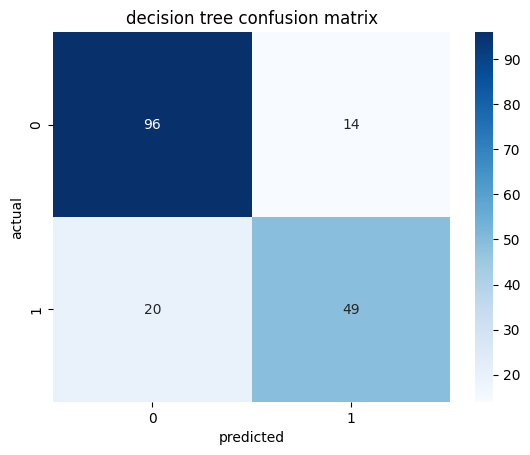

decision tree report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       110
           1       0.78      0.71      0.74        69

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179

random forest val acc: 0.816


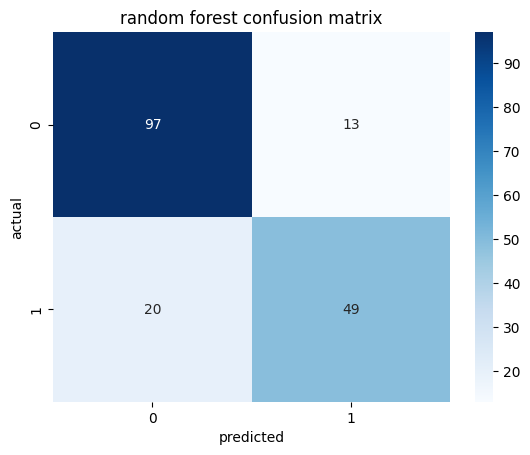

random forest report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       110
           1       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



In [72]:
# train on full train split & eval on hold-out
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

for name, clf in [("decision tree", dt), ("random forest", rf)]:
    y_pred = clf.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    print(f"{name} val acc: {acc:.3f}")
    cm = confusion_matrix(y_valid, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} confusion matrix")
    plt.xlabel('predicted'); plt.ylabel('actual')
    plt.show()
    print(f"{name} report:\n", classification_report(y_valid, y_pred))


In [73]:
# summarise hold-out accuracies in a small table
val_results = []
for name, model in [("decision tree", dt), ("random forest", rf)]:
    acc = accuracy_score(y_valid, model.predict(X_valid))
    val_results.append({
        "model": name,
        "validation_accuracy": acc
    })

val_summary = pd.DataFrame(val_results)
display(val_summary)


,model,validation_accuracy
0,decision tree,0.810056
1,random forest,0.815642


table confirms rf edges out dt by a few points on the hold-out set

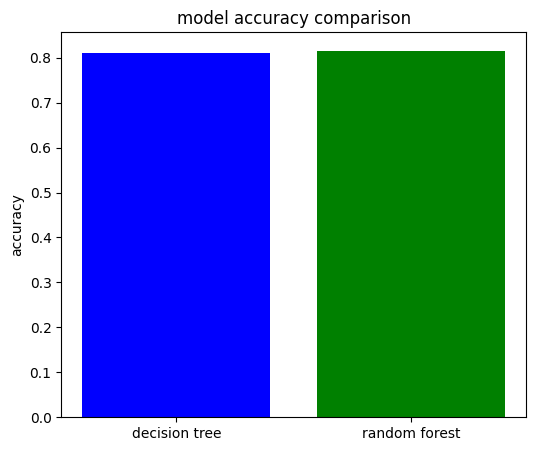

In [74]:
# compare model accuracies
names = ['decision tree','random forest']
accs  = [accuracy_score(y_valid, dt.predict(X_valid)),
         accuracy_score(y_valid, rf.predict(X_valid))]

plt.figure(figsize=(6,5))
plt.bar(names, accs, color=['blue','green'])
plt.title('model accuracy comparison')
plt.ylabel('accuracy')
plt.show()


 visually, random forest has slightly higher accuracy than decision tree

In [75]:
X_test = test_df.drop(columns=['PassengerId'])

# predict on the test set and show results inline
y_test_pred = rf.predict(X_test)
pred_df = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived_pred': y_test_pred
})
display(pred_df.head(20))


,PassengerId,Survived_pred
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0


 summary: 
 random forest and decision tree both ran at ~81% accuracy on the hold-out set  
 cross-validation showed rf ≈0.82 ± 0.04 vs dt ≈0.78 ± 0.03  
 top predictive features: fare, passenger class, age, family relationships (sibsp/parch)  
 drop unused text columns (name, ticket, cabin, embarked, passengerid) to simplify modeling  
 filling missing ages/fare with the median kept things consistent  
 rf is a bit better than dt but both models capture the same survival patterns 